# Validate the data
(test the data extracted from the video)

Modify Name="file_name_in_data_folder"

Landmark Tensor Shape: (15748, 68, 2)
Frame Distance From Ref Array Length: (15748,)


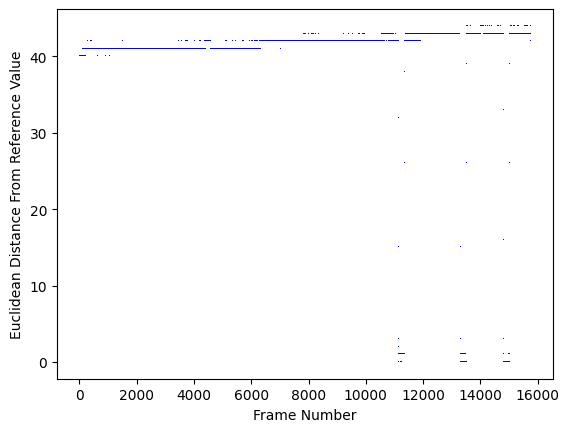

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Name = "file_name_in_data_folder"

landmark_tensor = np.load(f"data/{Name}_landmark.npy")
print(f"Landmark Tensor Shape: {landmark_tensor.shape}")

distances = np.load(f"data/{Name}_distance.npy")
print(f"Frame Distance From Ref Array Length: {distances.shape}")

x = range(distances.shape[0])
plt.plot(x, distances, ',b')
# plt.title("Cropped Frame Average Pixel Distance From Reference Frame")
plt.xlabel("Frame Number")
plt.ylabel("Euclidean Distance From Reference Value")
plt.show()


## Transform the distances data to the binary self-report signal
(With 17 seconds addition and 4 second time shifting)

Middle Distance Value = 20.0
Number Of Self-Reports: 3
Processed signal, 13 seconds positive reports before self-report and 8 seconds backward time-shifted


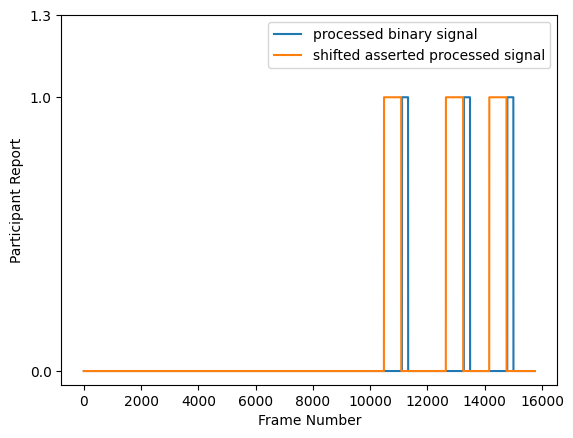

In [14]:
middle_distance = (np.mean(distances) // 2) # Threshold for the binary decision
print(f"Middle Distance Value = {middle_distance}")

roundBinary = np.vectorize(lambda t: 1 if (t < middle_distance) else 0)
binary_report = roundBinary(distances)

# Save the unshifted and unasserted signal
binary_report_old = binary_report.copy()

# Find the number of reports (210 frames per report)
def count_rep(arr):
    i = 0
    count = 0
    while i < len(arr):
        if arr[i] == 1:
            i += 240 # skip 8 seconds 
            count += 1
        else:
            i += 1
    return count

c = count_rep(binary_report)
print(f"Number Of Self-Reports: {c}")

# To add 13 seconds of report (for a total of 20 seconds of positive report) before the self-report, (13 seconds * 30 fps = 390 frames)
# 390 frames before the signal should be marked

def add_flag(binary_report):
    i = 0
    while i < len(binary_report):
        # Flag 390 frames back
        if binary_report[i] == 1:
            if i-390 >= 0:
                binary_report[i-390: i] = 1
        # go to next frame
        i += 1
    return binary_report

binary_report = add_flag(binary_report)

# To time-shift the signal 8 seconds backward (8 seconds * 30 fps = 240 frames)
# first 240 frames are removed and 240 frames are concatenated to the end of the signal      

binary_report = np.concatenate((np.split(binary_report, [240])[1], np.zeros(240)))

print("Processed signal, 13 seconds positive reports before self-report and 8 seconds backward time-shifted")

# Plot binary report
plt.plot(x, binary_report_old, label="processed binary signal")
plt.plot(x, binary_report, label="shifted asserted processed signal")
plt.legend(loc="upper right")
# plt.title("Participant Self Report")
plt.xlabel("Frame Number")
plt.ylabel("Participant Report")

plt.yticks([0, 1, 1.3])

plt.show()



## Transfrom the 68 landmark points to the face features
(Need to include the features module)

In [ ]:
import features

# To transform the (n, 68, 2) landmark tensor into the (n, 14) features matrix 
# (where n is the number of frames) the features module is needed 
n = landmark_tensor.shape[0]
print(f"n = {n} frames")

# Initialize the empty matrix of shape (n,14)
feature_matrix = np.ndarray((n, 14))

for idx, landmark_matrix in enumerate(landmark_tensor):
    feature_matrix[idx] = features.convert_landmark_points_to_features(landmark_matrix)

Example of MNAR plot


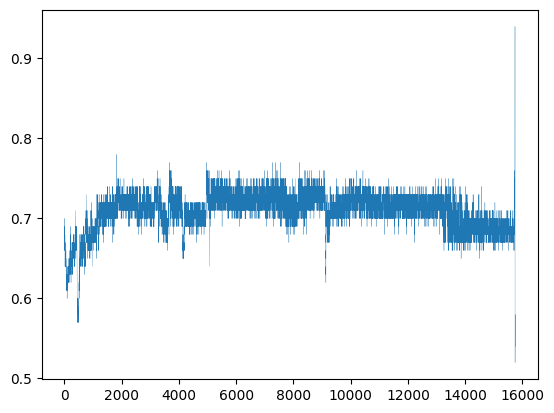

In [ ]:
# features in the feature_matrix by index
# [IMAR, LEAR, REAR, LEEAR, REEAR, NXP, NYP, OMAR, FXP, FYP, LFRR, RFRR, MNAR, MCAR]

leear = feature_matrix[:, 12]

# Example plot for mouth to nose aspect ratio per frame
print("Example of MNAR plot")
plt.plot(range(0, n), leear, linewidth=0.2)
plt.show()